In [1]:
# importation des bibliothèques
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from imutils import paths
import itertools
import os

In [2]:
# initialiser learning rate, number of epochs to train for, et batch size
INIT_LR = 1e-4
EPOCHS = 20
BS = 32

In [3]:
PATH = "dataset"
CATEGORIES = ["mohamed", "other", "youssef"]

In [4]:
# lire les images et leurs catégories
imagePaths = list(paths.list_images(PATH))
data = []
labels = []
for imagePath in imagePaths:
    label = imagePath.split(os.path.sep)[1]
    image = load_img(imagePath, color_mode='rgb', target_size=(224, 224))
    image = img_to_array(image)
    image = preprocess_input(image)
    
    data.append(image)
    labels.append(label)
    
data = np.array(data, dtype="float32")
labels = np.array(labels)

In [5]:
unique, counts = np.unique(labels, return_counts=True)

dict(zip(unique, counts))

{'mohamed': 995, 'other': 985, 'youssef': 999}

In [6]:
# one-hot encoding pour les labels
lb = LabelEncoder()
labels = lb.fit_transform(labels)

In [7]:
unique, counts = np.unique(labels, return_counts=True)

dict(zip(unique, counts))

{0: 995, 1: 985, 2: 999}

In [8]:
print(labels)

[0 0 0 ... 2 2 2]


In [9]:
# partitionner les données en fractionnements d'entraînement et de test en utilisant 80% de
# les données pour le Train et les 20% restants pour le Test
(x_train, x_test, y_train, y_test) = train_test_split(data, labels, test_size=0.2, stratify=labels, random_state=42)

C:\Users\Bennour\AppData\Local\Temp\ipykernel_8472\2348616803.py:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


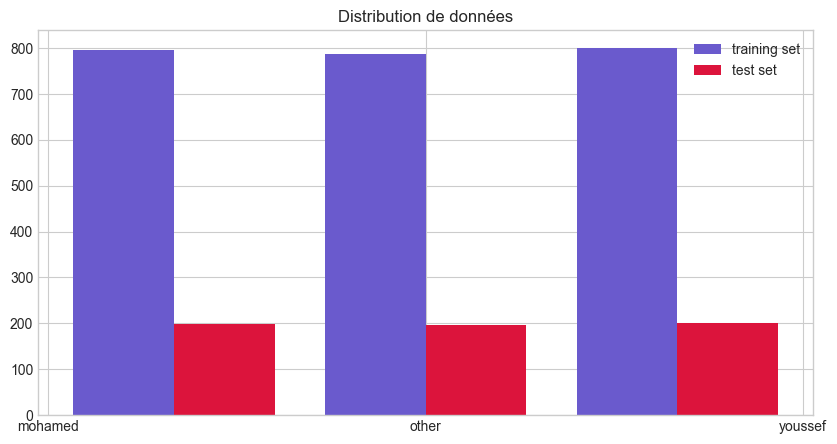

In [10]:
# tracer la distrubution de données entre "training" et "test" 
plt.figure(figsize=(10,5))
plt.style.use('seaborn-whitegrid')
plt.hist([y_train.flatten(), y_test.flatten()],bins=3, label=['training set', 'test set'], color=['slateblue', 'crimson'])
plt.xticks(np.arange(3), CATEGORIES)
plt.title("Distribution de données")
plt.legend()
plt.savefig(r"plot\Distribution.png")
plt.show()

In [11]:
# inisialiser un générateur pour augmentation des données
aug = ImageDataGenerator(
        rotation_range=20,
        zoom_range=0.15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.15,
        horizontal_flip=True,
        fill_mode="nearest"
)

In [12]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 10, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

In [13]:
img = np.expand_dims(plt.imread(imagePath),0)
aug_iter = aug.flow(img)
aug_img = [next(aug_iter)[0].astype(np.uint8) for i in range(10)]

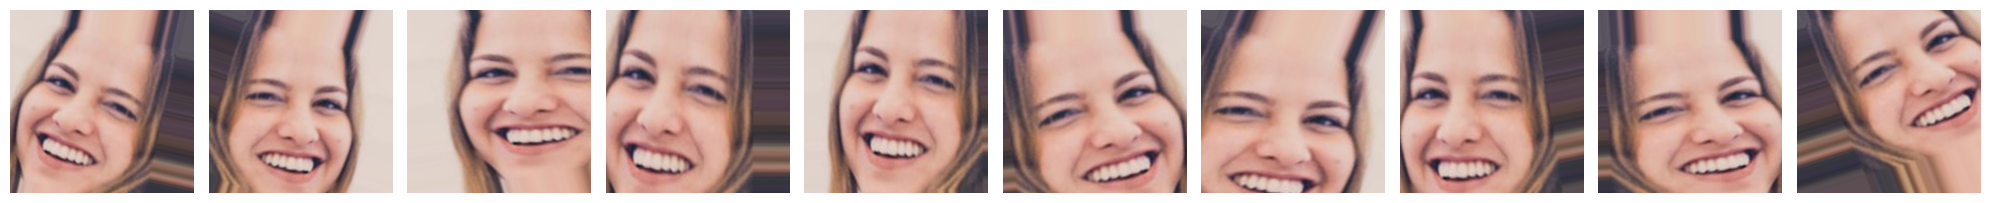

In [23]:
plotImages(aug_img)

In [14]:
# charger le réseau mobilenetve2, en veillant à ce que les ensembles de couches FC de tête soit désactivés
input_tensor = Input(shape=(224, 224, 3))
basemodel = MobileNetV2(input_tensor=input_tensor, weights="imagenet", include_top=False)

In [15]:
# construire la tête du modèle qui sera placée au-dessus du modèle de base
headmodel = basemodel.output
headmodel = AveragePooling2D(pool_size=(7,7))(headmodel)
headmodel = Flatten()(headmodel)
headmodel = Dense(128, activation='relu')(headmodel)
headModel = Dropout(0.5)(headmodel)
headmodel = Dense(3, activation='softmax')(headmodel)

In [16]:
model = Model(inputs=basemodel.input, outputs=headmodel)

In [17]:
basemodel.summary()
print("Number of layers in basemodel : ",len(basemodel.layers))

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                              

In [18]:
model.summary()
print("Number of layers in model : ",len(model.layers))

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                             

In [19]:
# boucle sur tous les layers de basemodel et "freeze" tous ces layers 
# pour qu'elles ne soient pas mises à jour lors du processus de training
for layer in basemodel.layers:
    layer.trainable = False

In [20]:
# enregistrer le meilleur modèle
checkpoint = ModelCheckpoint(filepath=r"model\best_model.hdf5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

In [21]:
# compiler le modèle
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(optimizer=opt, loss='sparse_categorical_crossentropy' , metrics=['accuracy'])

c:\Users\Bennour\anaconda3\envs\opencv_env\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [22]:
# entrainer "head" du réseau de neurones
head = model.fit(
    aug.flow(x_train, y_train, batch_size=BS, shuffle=True),
    steps_per_epoch = len(x_train) // BS,
    validation_data = (x_test, y_test),
    validation_steps = len(x_test) // BS,
    callbacks=[checkpoint],
    epochs = EPOCHS
)

Epoch 1/20
74/74 [==============================] - ETA: 0s - loss: 0.4969 - accuracy: 0.8371
Epoch 1: val_accuracy improved from -inf to 0.96477, saving model to model\best_model.hdf5
74/74 [==============================] - 226s 2s/step - loss: 0.4969 - accuracy: 0.8371 - val_loss: 0.2014 - val_accuracy: 0.9648
Epoch 2/20
74/74 [==============================] - ETA: 0s - loss: 0.1344 - accuracy: 0.9741
Epoch 2: val_accuracy improved from 0.96477 to 0.98658, saving model to model\best_model.hdf5
74/74 [==============================] - 95s 1s/step - loss: 0.1344 - accuracy: 0.9741 - val_loss: 0.0947 - val_accuracy: 0.9866
Epoch 3/20
74/74 [==============================] - ETA: 0s - loss: 0.0735 - accuracy: 0.9872
Epoch 3: val_accuracy improved from 0.98658 to 0.98826, saving model to model\best_model.hdf5
74/74 [==============================] - 100s 1s/step - loss: 0.0735 - accuracy: 0.9872 - val_loss: 0.0668 - val_accuracy: 0.9883
Epoch 4/20
74/74 [==============================] 

In [23]:
if os.path.isfile(r"model\face_model.h5") is False :
    model.save(r"model\face_model.h5", save_format='h5')

In [24]:
model = load_model(r"model\face_model.h5")

In [25]:
best_model = load_model(r"model\best_model.hdf5")

In [26]:
# faire des prédictions sur les données du test
predire = model.predict(x_test, batch_size=BS)
predire = np.argmax(predire, axis=1)

19/19 [==============================] - 23s 1s/step


In [27]:
y_true = y_test

In [28]:
cm = confusion_matrix(y_true=y_true, y_pred=predire)

In [29]:
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Matrice de confusion',
                        cmap=plt.cm.Purples):
    plt.figure(figsize=(10,6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    print(cm)

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            fontsize='x-large',
            color="white" if cm[i, j] > cm.mean() else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig(r"plot\Matrice de confusion.png") 

[[199   0   0]
 [  0 197   0]
 [  0   0 200]]


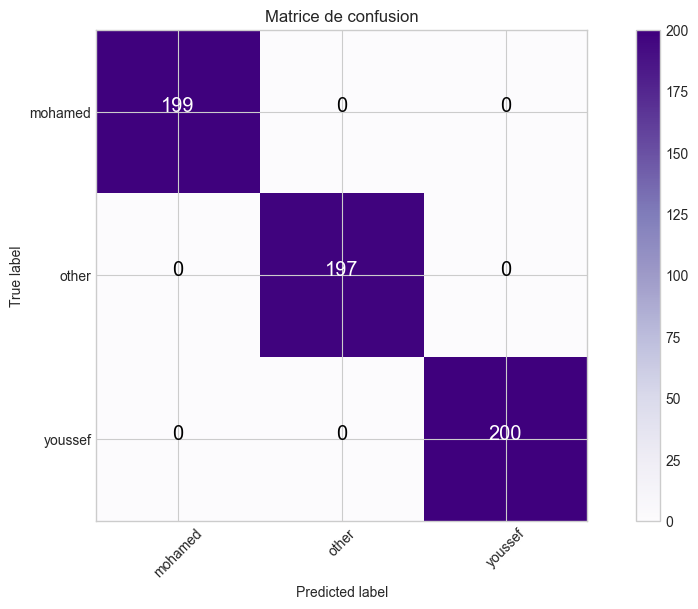

In [30]:
plot_confusion_matrix(cm=cm, classes=CATEGORIES, title='Matrice de confusion')

In [31]:
print(classification_report(y_true=y_true, y_pred=predire, target_names=CATEGORIES))

              precision    recall  f1-score   support

     mohamed       1.00      1.00      1.00       199
       other       1.00      1.00      1.00       197
     youssef       1.00      1.00      1.00       200

    accuracy                           1.00       596
   macro avg       1.00      1.00      1.00       596
weighted avg       1.00      1.00      1.00       596



In [32]:
model.evaluate(x_test, y_test)

19/19 [==============================] - 22s 1s/step - loss: 0.0083 - accuracy: 1.0000


[0.008344386704266071, 1.0]